In [1]:
# Common
import pandas as pd
import numpy as np
from typing import List, Dict
import time

# Machine learning
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep learning
import torch
import tensorflow as tf
from tensorflow import keras
import keras

from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Dense
from tensorflow.keras import Sequential


# Visualization
import plotly.graph_objects as go
import matplotlib.pyplot as plt

2023-11-14 15:14:41.837587: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 15:14:41.837686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 15:14:41.837785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 15:14:41.872768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SP500_PATH = '../data/processed/data_preprocess.csv'

In [3]:
df = pd.read_csv(SP500_PATH)
df.head()

,Unnamed: 0,time,open,high,low,close,Volume,Volume MA,MA,Histogram,MACD,Signal,RSI,RSI-based MA
0,88,2008-02-05 00:30:00+07:00,1395.38,1395.38,1382.82,1386.74,236,211.70,1378.457978,3.242913,10.103625,6.860712,64.949508,58.353508
1,89,2008-02-05 01:30:00+07:00,1386.55,1389.31,1382.19,1388.41,237,215.35,1377.654607,3.026444,10.643767,7.617323,65.639255,59.160424
2,90,2008-02-05 02:30:00+07:00,1388.29,1389.81,1382.94,1383.42,232,215.15,1376.867416,2.344218,10.547596,8.203378,61.730279,59.511266
3,91,2008-02-05 03:30:00+07:00,1383.62,1386.17,1381.18,1382.46,156,215.15,1376.148652,1.657671,10.275467,8.617796,60.977916,59.951720
4,92,2008-02-06 00:30:00+07:00,1380.28,1380.28,1352.63,1360.23,232,214.90,1375.191124,-0.356775,8.171827,8.528602,46.764504,59.347106


In [4]:
df.describe()

,Unnamed: 0,open,high,low,close,Volume,Volume MA,MA,Histogram,MACD,Signal,RSI,RSI-based MA
count,20743.000000,20743.000000,20743.000000,20743.000000,20743.000000,2.074300e+04,2.074300e+04,20743.000000,20743.000000,20743.000000,20743.000000,20743.000000,20743.000000
mean,10459.000000,2531.818608,2536.954354,2526.436213,2531.874033,4.598991e+07,4.583565e+07,2526.191483,0.002904,0.918152,0.915247,53.292033,53.291474
std,5988.132653,1023.932422,1025.936211,1021.816953,1023.967649,1.381925e+08,1.183950e+08,1022.068305,3.980443,13.029936,12.243396,13.464366,11.505732
min,88.000000,677.410000,678.870000,672.560000,674.700000,0.000000e+00,0.000000e+00,741.537191,-24.384358,-97.625031,-84.847051,6.818337,13.619441
25%,5273.500000,1881.895000,1886.325000,1877.510000,1881.735000,4.800000e+02,5.656500e+02,1883.883202,-1.631422,-3.671863,-3.419735,43.709981,44.923456
50%,10459.000000,2389.120000,2391.440000,2386.320000,2388.890000,3.599000e+03,3.410700e+03,2388.005843,-0.110019,2.291144,2.287039,54.259546,53.959290
75%,15644.500000,3165.695000,3172.350000,3157.220000,3167.000000,3.600000e+03,3.419850e+03,3132.390449,1.555567,7.387446,6.980133,63.513704,62.045199
max,20830.000000,4813.260000,4818.620000,4805.640000,4813.240000,2.644078e+09,5.980679e+08,4749.065393,26.963073,59.068995,50.627442,90.978283,83.697112


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20743 entries, 0 to 20742
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    20743 non-null  int64  
 1   time          20743 non-null  object 
 2   open          20743 non-null  float64
 3   high          20743 non-null  float64
 4   low           20743 non-null  float64
 5   close         20743 non-null  float64
 6   Volume        20743 non-null  int64  
 7   Volume MA     20743 non-null  float64
 8   MA            20743 non-null  float64
 9   Histogram     20743 non-null  float64
 10  MACD          20743 non-null  float64
 11  Signal        20743 non-null  float64
 12  RSI           20743 non-null  float64
 13  RSI-based MA  20743 non-null  float64
dtypes: float64(11), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df["time"] = pd.to_datetime(df.time)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20743 entries, 0 to 20742
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   Unnamed: 0    20743 non-null  int64                    
 1   time          20743 non-null  datetime64[ns, UTC+07:00]
 2   open          20743 non-null  float64                  
 3   high          20743 non-null  float64                  
 4   low           20743 non-null  float64                  
 5   close         20743 non-null  float64                  
 6   Volume        20743 non-null  int64                    
 7   Volume MA     20743 non-null  float64                  
 8   MA            20743 non-null  float64                  
 9   Histogram     20743 non-null  float64                  
 10  MACD          20743 non-null  float64                  
 11  Signal        20743 non-null  float64                  
 12  RSI           20743 non-null  fl

In [7]:
print('Check for N/A:\n' ,df.isna().sum())
print('Check for NULL:\n' ,df.isnull().sum())


Check for N/A:
 Unnamed: 0      0
time            0
open            0
high            0
low             0
close           0
Volume          0
Volume MA       0
MA              0
Histogram       0
MACD            0
Signal          0
RSI             0
RSI-based MA    0
dtype: int64
Check for NULL:
 Unnamed: 0      0
time            0
open            0
high            0
low             0
close           0
Volume          0
Volume MA       0
MA              0
Histogram       0
MACD            0
Signal          0
RSI             0
RSI-based MA    0
dtype: int64


In [8]:
start = df["time"].min()
end = df["time"].max()
print(f"Begin date: {start}\nEnd date: {end}\nDuration: {end-start}")

Begin date: 2008-02-05 00:30:00+07:00
End date: 2023-04-05 02:30:00+07:00
Duration: 5538 days 02:00:00


In [9]:
fig = go.Figure(data = [go.Candlestick(
                x = df['time'],
                open = df['open'],
                high = df['high'],
                low = df['low'],
                close = df['close'])])

fig.show()

In [23]:
from dataclasses import dataclass
@dataclass
class TSConfig:
    train_features  = df.columns[2:]
    pred_features   = [
        'high',
        'low',
    ]
    n_steps         =   7
    n_classes       =   len(pred_features)
    n_features      =   len(train_features)
    batch_size      =   16

In [24]:
def read_csv(path: str, train_cols, target_cols, return_np: bool):
    """
    Args:
        path: path to the .csv file
        col_name: names of columns to extract features
        return_np:  if true then return the numpy array of features
    Return:
        results: dict{
            "frame": original frame read by pandas given the .csv file
            "frame_cols": frame that just includes the given column names
            "feature":  if return_np is true then return the numpy array for the features
        }
        , col_name: name of the column
    """
    print(path)
    results = dict()
    df                          = pd.read_csv(path)
    feature_frame               = df[train_cols]
    target_frame                = df[target_cols]

    results['frame']            = df
    results['feature_frame']    = feature_frame
    results['target_frame']     = target_frame
    results['feature']          = None
    results['target']           = None

    if return_np:
        feature_arr = feature_frame.to_numpy()
        target_arr  = target_frame.to_numpy()
        if not isinstance(feature_arr, np.ndarray):
            raise TypeError("Feature array must be numpy array")
        results['feature']  = feature_arr
        results['target']   = target_arr
    return results

def create_data_train(seq_feature, seq_target, n_steps):
    """
    Arg:
        seq_feature: the raw feature of data
    Return:
        (x_train, y_train): torch tensor
        x_train: (total - num_steps + 1, num_steps, num_features)
        y_train: (total - num_steps + 1, 1)
    """
    total, _ = seq_feature.shape

    div      = total % n_steps
    index    = (total // n_steps) * n_steps
    seq_feature = seq_feature[:index, :]
    curr_step = 0
    x_train, y_train = [], []

    while(curr_step < index):
        if curr_step + n_steps >= index:
            break
        x_train.append(seq_feature[curr_step:curr_step+n_steps, :])
        y_train.append(seq_target[curr_step + n_steps])

        curr_step += 1

    assert len(x_train) == len(y_train), "Number of samples must be the same of labels"
    x_train = torch.Tensor(np.stack(x_train, axis = 0))
    y_train = torch.Tensor(np.stack(y_train, axis = 0))

    return x_train, y_train

In [25]:
class Processor:

    def __init__(self):
        pass

    def apply_minmax_scale(self, input):
      """
      Arg:
        input: serie
      Return:
        scale: normalized serie
        (max_scale, min_scale): max and min of serie
      """
      samples, n_feature = input.shape
      max_scale           = np.max(input, axis = 0, keepdims = True)
      min_scale           = np.min(input, axis = 0, keepdims = True)
      assert max_scale.shape[1] == n_feature, "Error in preserving the number of features"
      scale               = (input - min_scale) / (max_scale - min_scale)
      return scale, (max_scale, min_scale)

    def re_scaler(self, scaler, max_scale, min_scale):
      """
      Arg:
        scaler: scaled serie
      Return:
        undo normalization on serie
      """
      return scaler * (max_scale - min_scale) + min_scale

In [26]:
ts_config = TSConfig()
processor = Processor()
data_frame = read_csv(SP500_PATH,
                      ts_config.train_features,
                      ts_config.pred_features,
                      return_np = True)

../data/processed/data_preprocess.csv


In [27]:
feature = data_frame['feature']
target = data_frame['target']
print(f"{feature.shape},{target.shape}")

(20743, 12),(20743, 2)


In [28]:
feature, (feature_max_scale, feature_min_scale) = processor.apply_minmax_scale(feature)
target, (target_max_scale, target_min_scale) = processor.apply_minmax_scale(target)

In [29]:
seq_steps = 7
X_ML, Y_ML = create_data_train(feature, target, seq_steps)
X = X_ML.detach().cpu().numpy()
Y = Y_ML.detach().cpu().numpy()

In [30]:
train_ratio = 0.8
split_idx = int(X.shape[0] * train_ratio)
x_train, y_train = X[:split_idx, :, :], Y[:split_idx, :]
x_test, y_test   = X[split_idx:, :, :], Y[split_idx:, :]
es = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = "min",
    restore_best_weights = True
)
print(x_train.shape, y_train.shape)

(16587, 7, 12) (16587, 2)


In [31]:
def eval_svr(x_train, y_train, class_target, show_shape = False):
  x_train_ml = x_train[: , :, class_target]
  y_train_ml = y_train[ :, class_target]
  x_test_ml = x_test[: , :, class_target]
  y_test_ml = y_test[: , class_target]
  if show_shape == True:
    print(f"{x_train_ml.shape},{y_train_ml.shape}")
    return
  svr_model = SVR(kernel = 'rbf',
                  C = 1e3,
                  gamma = 'scale')

  svr_model.fit(x_train_ml, y_train_ml)

  test_predict = svr_model.predict(x_test_ml)

  y_test_rescale = processor.re_scaler(y_test_ml,
                                  target_max_scale[:, class_target],
                                  target_min_scale[:, class_target])
  pred_rescale   = processor.re_scaler(test_predict,
                                  target_max_scale[:, class_target],
                                  target_min_scale[:, class_target])

  test_predict = test_predict.reshape(-1,1)

  mean_sqr_err = mean_squared_error(y_test_rescale, pred_rescale)
  mean_abs_err = mean_absolute_error(y_test_rescale, pred_rescale)
  r_square     = r2_score(y_test_rescale, pred_rescale)
  s = pd.Series({
            'Model': "SVR",
            'Feature': ts_config.pred_features[class_target],
            'MSE': mean_sqr_err,
            'MAE':mean_abs_err,
            'R2' : r_square,
            'Inference': None
        })
  return s

In [32]:
eval_svr(x_train, y_train, 0)

Model                   SVR
Feature                high
MSE          2539127.973555
MAE             1471.498879
R2               -26.892077
Inference              None
dtype: object

In [33]:
tf.keras.backend.clear_session()
gru_model = Sequential(name = "Stacked_GRU")
gru_model.add(GRU(64,
                  return_sequences = True,
                  input_shape = (ts_config.n_steps, ts_config.n_features)))
gru_model.add(GRU(64))
gru_model.add(Dense(ts_config.n_classes))
gru_model.compile(loss='mean_squared_error',optimizer='adam')

In [34]:
gru_model.fit(
    x_train,
    y_train,
    validation_split = 0.1,
    epochs = 10,
    batch_size = 16,
    callbacks = [es],
    verbose = 2
)

Epoch 1/10


2023-11-14 15:20:58.166411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-14 15:21:00.858112: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f301efa7da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 15:21:00.858223: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2023-11-14 15:21:00.909322: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 15:21:01.725069: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


933/933 - 35s - loss: 5.6557e-04 - val_loss: 5.7730e-05 - 35s/epoch - 38ms/step
Epoch 2/10
933/933 - 15s - loss: 6.8002e-06 - val_loss: 5.5588e-05 - 15s/epoch - 17ms/step
Epoch 3/10
933/933 - 15s - loss: 8.2927e-06 - val_loss: 5.7108e-05 - 15s/epoch - 16ms/step


In [35]:
gru_model.summary()

Model: "Stacked_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 64)             14976     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 40066 (156.51 KB)
Trainable params: 40066 (156.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
tf.keras.backend.clear_session()
lstm_model = Sequential(name = "Stacked_LSTM")
lstm_model.add(LSTM(64,
                    return_sequences = True,
                    input_shape = (ts_config.n_steps, ts_config.n_features)))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(ts_config.n_classes))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [37]:
lstm_model.fit(
    x_train,
    y_train,
    validation_split = 0.1,
    epochs = 10,
    batch_size = 16,
    callbacks = [es],
    verbose = 2
)

Epoch 1/10
933/933 - 31s - loss: 5.2292e-04 - val_loss: 1.1908e-04 - 31s/epoch - 33ms/step
Epoch 2/10
933/933 - 16s - loss: 1.2292e-05 - val_loss: 1.3382e-04 - 16s/epoch - 17ms/step


In [38]:
lstm_model.summary()

Model: "Stacked_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             19712     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 52866 (206.51 KB)
Trainable params: 52866 (206.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
tf.keras.backend.clear_session()
bidir_model=Sequential(name = "Stacked_BiLSTM")
bidir_model.add(Bidirectional(
    LSTM(64,
        return_sequences = True,
        input_shape = (ts_config.n_steps, ts_config.n_features))))
bidir_model.add(Bidirectional(LSTM(64)))
bidir_model.add(Dense(ts_config.n_classes))
bidir_model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [40]:
bidir_model.fit(
    x_train,
    y_train,
    validation_split = 0.1,
    epochs = 10,
    batch_size = 16,
    callbacks = [es],
    verbose = 2
)

Epoch 1/10
933/933 - 63s - loss: 4.9869e-04 - val_loss: 7.6916e-05 - 63s/epoch - 67ms/step
Epoch 2/10
933/933 - 23s - loss: 1.1315e-05 - val_loss: 6.9970e-05 - 23s/epoch - 25ms/step
Epoch 3/10
933/933 - 24s - loss: 1.1928e-05 - val_loss: 5.3702e-05 - 24s/epoch - 26ms/step
Epoch 4/10
933/933 - 22s - loss: 1.5459e-05 - val_loss: 5.1628e-05 - 22s/epoch - 24ms/step
Epoch 5/10
933/933 - 22s - loss: 1.2061e-05 - val_loss: 4.2551e-05 - 22s/epoch - 24ms/step
Epoch 6/10
933/933 - 23s - loss: 1.8265e-05 - val_loss: 4.2563e-05 - 23s/epoch - 24ms/step


In [41]:
bidir_model.summary()

Model: "Stacked_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 7, 128)            39424     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 138498 (541.01 KB)
Trainable params: 138498 (541.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
tf.keras.backend.clear_session()
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector
    
att_bidir_model=Sequential(name = "Attention_BiLSTM")
att_bidir_model.add(Bidirectional(
    LSTM(64,
        return_sequences = True,
        input_shape = (ts_config.n_steps, ts_config.n_features))))
att_bidir_model.add(Attention(64))
att_bidir_model.add(Dense(ts_config.n_classes))
att_bidir_model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [43]:
att_bidir_model.fit(
    x_train,
    y_train,
    validation_split = 0.1,
    epochs = 10,
    batch_size = 16,
    callbacks = [es],
    verbose = 2
    
)

Epoch 1/10
933/933 - 43s - loss: 6.7241e-04 - val_loss: 1.0279e-04 - 43s/epoch - 46ms/step
Epoch 2/10
933/933 - 19s - loss: 9.5852e-06 - val_loss: 6.6233e-05 - 19s/epoch - 20ms/step
Epoch 3/10
933/933 - 18s - loss: 1.0067e-05 - val_loss: 5.0744e-05 - 18s/epoch - 19ms/step
Epoch 4/10
933/933 - 20s - loss: 1.1751e-05 - val_loss: 6.3142e-05 - 20s/epoch - 21ms/step


In [44]:
att_bidir_model.summary()

Model: "Attention_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 7, 128)            39424     
 al)                                                             
                                                                 
 attention (Attention)       (None, 128)               8321      
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 48003 (187.51 KB)
Trainable params: 48003 (187.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
y_test_scale = processor.re_scaler(y_test, target_max_scale, target_min_scale)
models = ['svr_model', gru_model, lstm_model, bidir_model, att_bidir_model]
init_rows = []
sr = []
for idx, category in enumerate(ts_config.pred_features):
    for model in models:
        if model == models[0]:
          s = eval_svr(x_train, y_train, idx)
        else:
          tf.keras.backend.clear_session()
          start = time.time()
          predictions = model.predict(x_test, verbose = 0)
          timer = time.time()-start
          predictions_scale = processor.re_scaler(predictions, target_max_scale, target_min_scale)
          cate_mse = mean_squared_error(y_test_scale[:, idx], predictions_scale[:, idx])
          cate_mae = mean_absolute_error(y_test_scale[:, idx], predictions_scale[:, idx])
          cate_rsqr = r2_score(y_test_scale[:, idx], predictions_scale[:, idx])
          s = pd.Series({
              'Model': model.name,
              'Feature': ts_config.pred_features[idx],
              'MSE': cate_mse,
              'MAE': cate_mae,
              'R2' : cate_rsqr,
              'Inference': timer,
              'Num of params': model.count_params()
          })
        init_rows.append(s)
    sr.append(pd.DataFrame(init_rows))
    init_rows =[]

In [46]:
def highlight(s):
    s.highlight_max(subset=['R2'],
                    axis = 0,
                    props = "font-weight:bold")
    s.highlight_min(subset=['MSE', 'MAE', 'Inference'],
                    axis = 0,
                    props = "font-weight:bold")
    s.format(subset= ["MSE", "MAE", "R2"],
             precision=3,
             thousands=",")
    s.format(subset = ["Num of params"], 
             precision = 0)
    return s
for idx,_ in enumerate(sr):
    display(sr[idx].style.pipe(highlight))

,Model,Feature,MSE,MAE,R2,Inference,Num of params
0,SVR,high,"2,539,127.974","1,471.499",-26.892,nan,nan
1,Stacked_GRU,high,"37,127.850",164.680,0.592,4.732383,40066
2,Stacked_LSTM,high,"75,675.119",253.480,0.169,5.600296,52866
3,Stacked_BiLSTM,high,"2,591.803",41.338,0.972,8.816752,138498
4,Attention_BiLSTM,high,"15,824.742",111.470,0.826,5.072369,48003


,Model,Feature,MSE,MAE,R2,Inference,Num of params
0,SVR,low,"2,415,262.724","1,427.071",-25.278,nan,nan
1,Stacked_GRU,low,"38,250.557",171.477,0.584,2.487608,40066
2,Stacked_LSTM,low,"43,726.619",195.821,0.524,3.177541,52866
3,Stacked_BiLSTM,low,"7,643.569",77.340,0.917,3.706829,138498
4,Attention_BiLSTM,low,"9,768.469",80.754,0.894,2.867185,48003


130/130 [==============================] - 2s 18ms/step


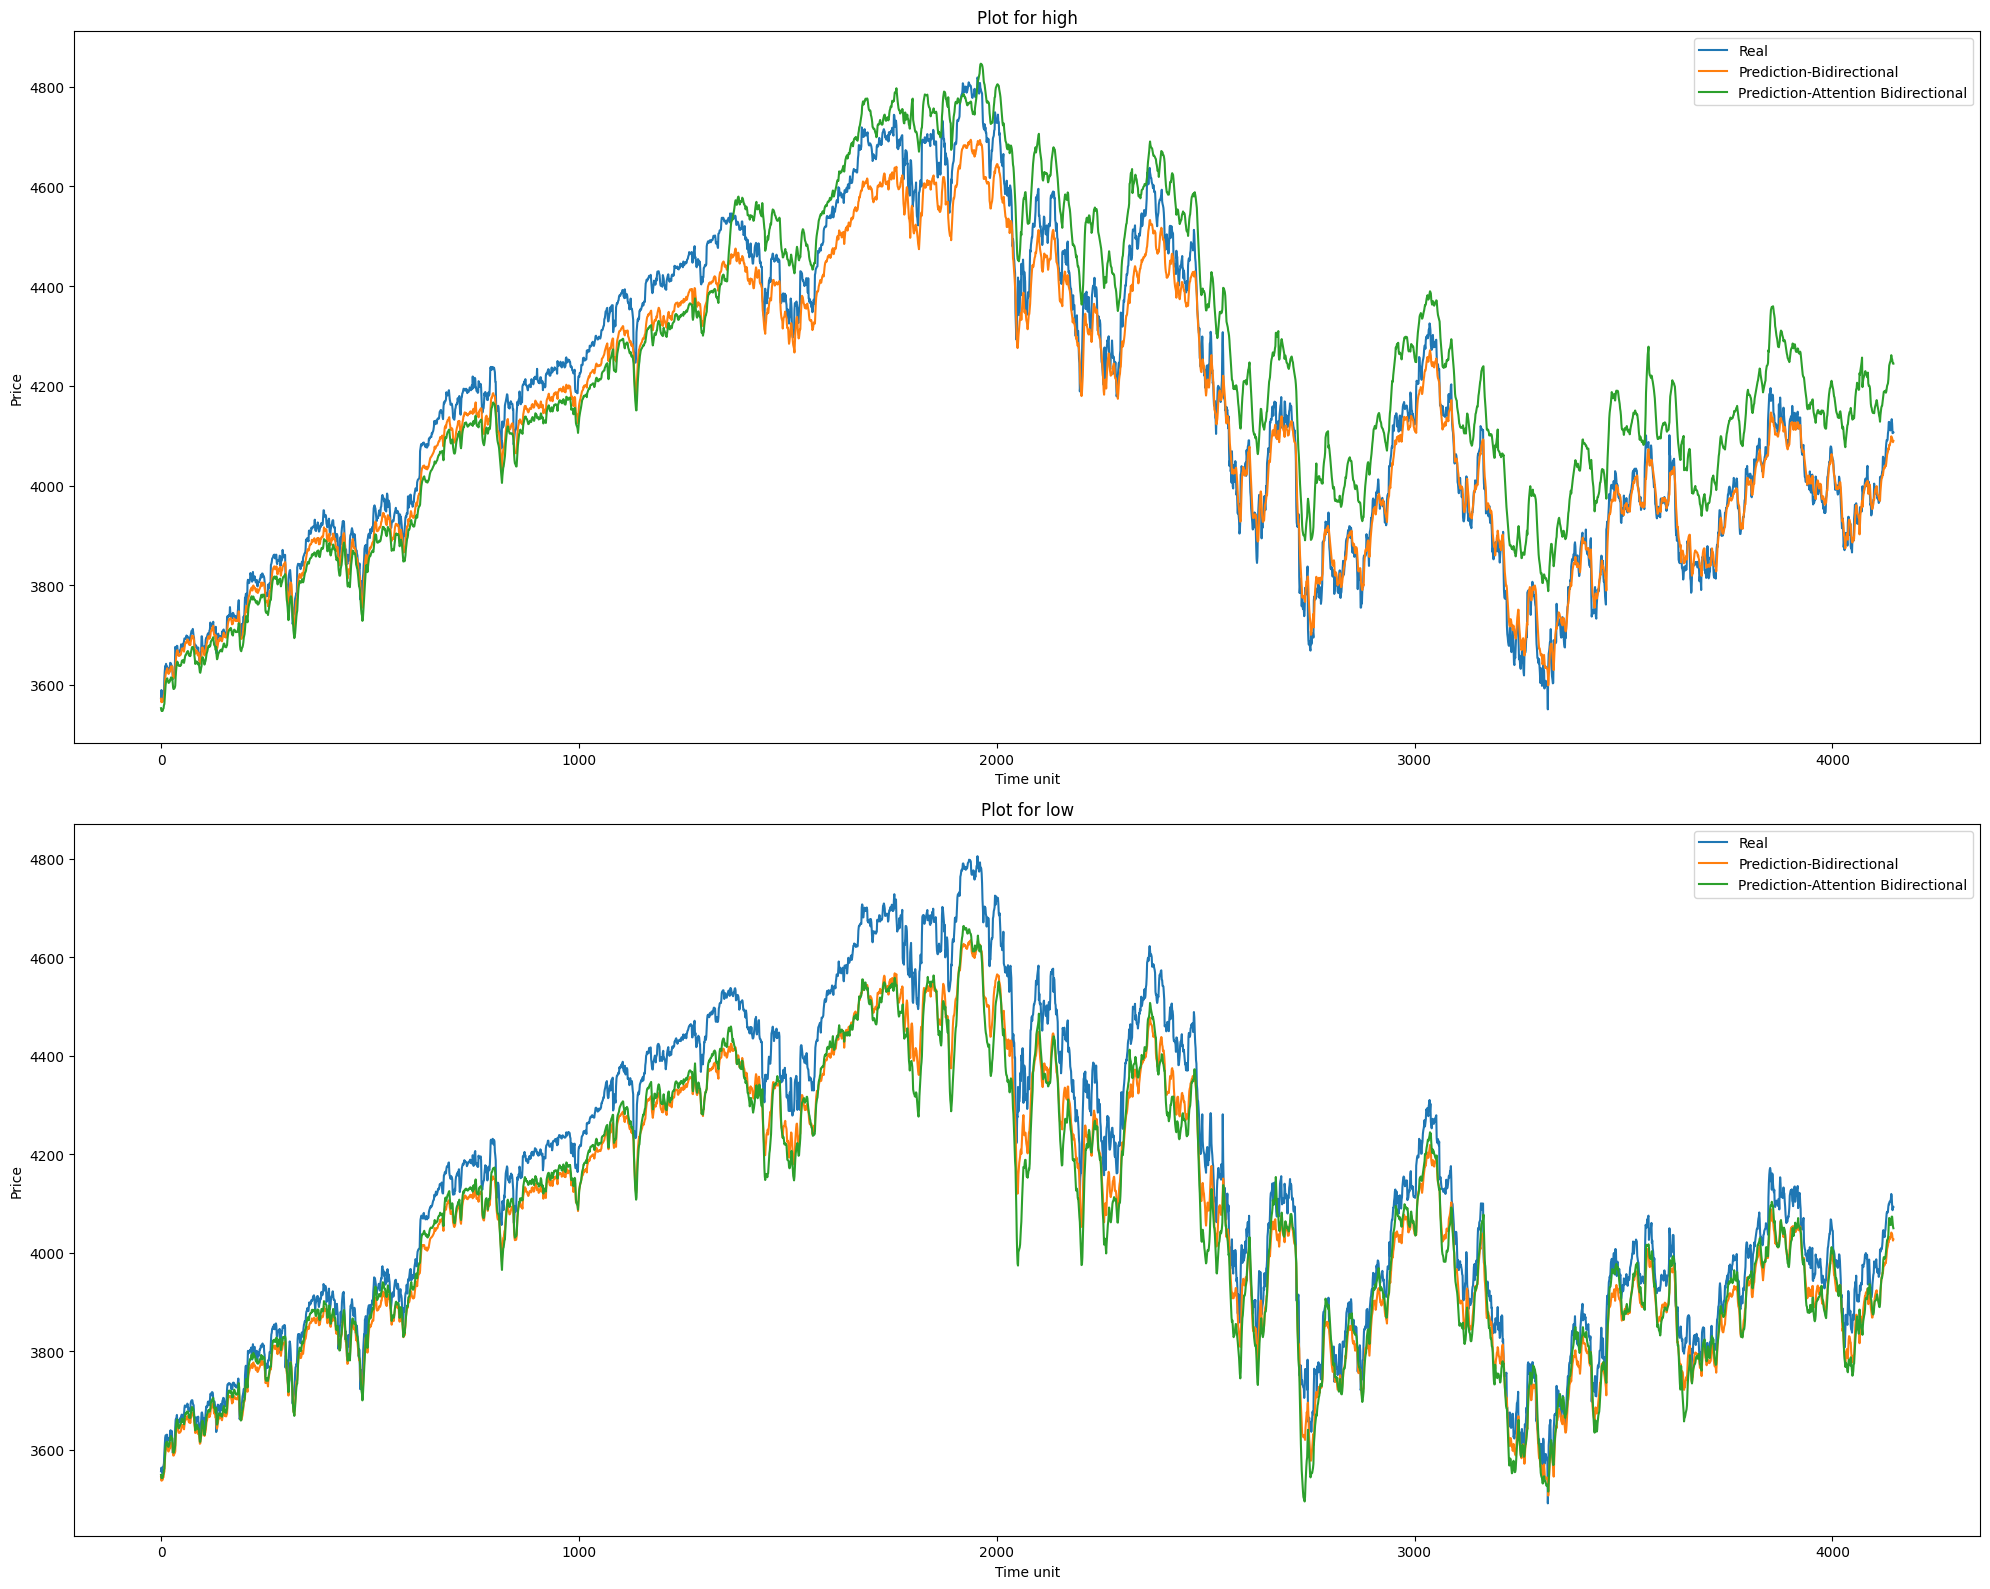

In [47]:
fig, axs = plt.subplots(len(ts_config.pred_features), 1, figsize=(20, 16))
gru_predict = gru_model.predict(x_test)
lstm_predict = lstm_model.predict(x_test)
bidir_predict = bidir_model.predict(x_test)
att_bidir_predict = att_bidir_model.predict(x_test)
data = [
    y_test,
    lstm_predict,
    gru_predict,
    bidir_predict,
    att_bidir_predict
]
data = [processor.re_scaler(item, target_max_scale, target_min_scale) for item in data]
cls = ts_config.pred_features
for i, ax in enumerate(axs.flat):
    test_size =len(data[0][:,i])
    x = np.arange(test_size)
    ax.plot(x, data[0][:, i], label='Real')
    #ax.plot(x, data[1][:, i], label='Prediction-LSTM')
    #ax.plot(x, data[2][:, i], label='Prediction-GRU')
    ax.plot(x, data[3][:, i], label='Prediction-Bidirectional')
    ax.plot(x, data[4][:, i], label='Prediction-Attention Bidirectional')

    # Add title and labels
    ax.set_title(f'Plot for {cls[i]}')
    ax.set_xlabel('Time unit')
    ax.set_ylabel('Price')
    # Add a legend
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()